In [1]:
import sqlite3
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os

DB_NAME = 'rxn_db.sql'
domains = ["amides", "sulfonamides", "heterocycles", "alkyl amines","anilines",  
           "ROH", "ArOH", "ArSH", "malonates", "Bpin"]
tables = ["Nucleophiles", "Electrophiles", "Catalysts","Bases", "Solvents"]
N_nucs = domains[:2]+["ROH"]+domains[2:5]

In [2]:
def prep_id_yield_arrays(db_name=DB_NAME):
    ''' Prepares numpy arrays of id's of rxn components and their binary yields.
    
    Parameters
    ----------
    db_name : str
        directory of sql file to access
        
    Returns
    -------
    full_id_arrays_by_nuc, full_yields_by_nuc : dicts
        key : domain (str)
        value : array (np.2d/1darray)
    '''
    conn = sqlite3.connect(db_name)
    cur = conn.cursor()
    get_rxns_ids = '''  SELECT NucleophileId, ElectrophileId, CatalystId, BaseId, SolventId, 
                            [Group], Domain
                        FROM "Reactions"
                       '''
    res = cur.execute(get_rxns_ids).fetchall()
    conn.close()
    
    full_id_arrays_by_nuc = {}
    full_yields_by_nuc = {}

    for row in res:
        id_array = row[:5]
        yield_group = row[-2]
        domain = row[-1]
        prev_array = full_id_arrays_by_nuc.get(domain, [])  # 5 Rxn components
        prev_array.append(id_array)
        full_id_arrays_by_nuc.update({domain: prev_array})

        prev_yield = full_yields_by_nuc.get(domain, [])
        if yield_group == '0':
            prev_yield.append(0)
        else:
            prev_yield.append(1)
        full_yields_by_nuc.update({domain: prev_yield})
    for k, v in full_id_arrays_by_nuc.items():
        full_id_arrays_by_nuc[k] = np.array(v)
        full_yields_by_nuc[k] = np.array(full_yields_by_nuc[k])
    return full_id_arrays_by_nuc, full_yields_by_nuc


def get_all_desc(table_name, db_name):
    ''' Retrieves all columns (descriptor names) from database.
    
    Parameters
    ----------
    table_name : str
        {"Nucleophiles", "Electrophiles", "Catalysts", "Bases", "Solvents"}
    db_name : str
        directory of sql file to access
    
    Returns
    --------
    all_vals : list of tuples
        all column names in data-table.
    '''
    conn = sqlite3.connect(db_name)
    cur = conn.cursor()
    get_desc = f''' SELECT *
                    FROM {table_name}'''
    all_vals = cur.execute(get_desc).fetchall()
    conn.close()
    return all_vals
    
    
def prep_desc_array(id_array_dict, domain_list, table_list, db_name):
    ''' Prepares descriptor array based on the id array.
    
    Parameters
    ----------
    id_array_dict : dict
        key : str (domain name)
        val : np.2darray 
    domain_list : list of str
        domains to prepare descriptor arrays for.
    table_list : list of str
        names of tables in database.
    db_name : str
        directory sql file to access.
        
    Returns
    -------
    desc_arrays_by_nuc : dict
        key : str (domain name)
        val : np.2darray
    '''
    # Preparing Descriptor Lookup Table
    comp_desc = {}
    for table in table_list:
        comp_desc.update({table: get_all_desc(table, db_name)})
    # convert each row of id's into their corresponding descriptors
    desc_arrays_by_nuc = {}
    num_descs = [6, 27, 26, 7, 7]  # number of descriptors for each component
    for nuc in domain_list:
        num_rxns = id_array_dict[nuc].shape[0]
        desc_array = np.zeros((num_rxns, sum(num_descs)))
        for i in range(num_rxns):
            last_col = 0
            for j in range(5):  # number of reaction components
                comp = table_list[j]
                comp_id = id_array_dict[nuc][i, j]
                # Tables of different components have different columns
                if j in [0, 1, 4]:
                    desc_array[i, last_col:last_col+num_descs[j]] = comp_desc[comp][comp_id-1][2:]
                else:
                    desc_array[i, last_col:last_col+num_descs[j]] = comp_desc[comp][comp_id-1][3:]
                last_col += num_descs[j]
        desc_arrays_by_nuc.update({nuc: desc_array})
    return desc_arrays_by_nuc


def sort_out_double_counted_conditions(id_array, desc_array, y_array):
    ''' Some reactions coming from different sources are counted
    twice. Combines these; yields are collected following OR logic.
    For this specific dataset, only occurs up to two times.
    
    Parameters
    ----------
    id_array, desc_array, y_array: np.2d/2d/1d arrays
    
    Returns
    -------
    corr_id_array, corr_desc_array, corr_y_array
    '''
    rxn_cond_dict = {}
    # Sweep through all rxns
    for i, row in enumerate(id_array):
        if tuple(row[1:]) not in rxn_cond_dict.keys():
            rxn_cond_dict.update({tuple(row[1:]):[[i], [y_array[i]]]})
        else :
            rxn_cond_dict[tuple(row[1:])][0].append(i)
            rxn_cond_dict[tuple(row[1:])][1].append(y_array[i])
    # Check double counted
    inds_not_to_use = []
    for k, v in rxn_cond_dict.items():
        if len(v[0])!=1:
            if sum(v[1]) not in [0, len(v[1])]:
                inds_not_to_use.append(v[0][y_array.index(0)])
            else :
                inds_not_to_use.append(v[0][0])
    # Correcting arrays
    corr_id_array = np.zeros((id_array.shape[0]-len(inds_not_to_use), 5))
    corr_desc_array = np.zeros((desc_array.shape[0]-len(inds_not_to_use), desc_array.shape[1]))
    corr_y_array = np.zeros(len(y_array)-len(inds_not_to_use))
    row_counter = 0
    for i, row in enumerate(id_array):
        if i not in inds_not_to_use :
            corr_id_array[row_counter,:] = id_array[i,:]
            corr_desc_array[row_counter,:] = desc_array[i,:]
            corr_y_array[row_counter] = y_array[i]
            row_counter += 1
        else :
            continue
    return corr_id_array, corr_desc_array, corr_y_array

## Preparing Full Arrays

In [3]:
if not os.path.exists("./array_joblibs/full_id_arrays_by_nuc.joblib"):
    id_arrays_by_nuc, y_arrays_by_nuc = prep_id_yield_arrays(DB_NAME)
    desc_array_by_nuc = prep_desc_array(full_id_arrays_by_nuc, domains,
                                      tables, DB_NAME)

    full_id_arrays_by_nuc, full_desc_arrays_by_nuc,\
    full_y_arrays_by_nuc = {}, {}, {} 
    for domain in domains : 
        single_id, single_desc, single_y = sort_out_double_counted_conditions(
                    id_arrays_by_nuc[domain], 
                    desc_array_by_nuc[domain], 
                    y_arrays_by_nuc[domain]
        )
        full_id_arrays_by_nuc.update({domain:single_id})
        full_desc_arrays_by_nuc.update({domain:single_desc})
        full_y_arrays_by_nuc.update({domain:single_y})

    joblib.dump(full_id_arrays_by_nuc, "./array_joblibs/full_id_arrays_by_nuc.joblib")
    joblib.dump(full_desc_arrays_by_nuc, "./array_joblibs/full_desc_arrays_by_nuc.joblib")
    joblib.dump(full_y_arrays_by_nuc, "./array_joblibs/full_y_arrays_by_nuc.joblib")

else : 
    full_id_arrays_by_nuc = joblib.load("./array_joblibs/full_id_arrays_by_nuc.joblib")
    full_desc_arrays_by_nuc = joblib.load("./array_joblibs/full_desc_arrays_by_nuc.joblib")
    full_y_arrays_by_nuc = joblib.load("./array_joblibs/full_y_arrays_by_nuc.joblib")

## Exploratory Data Analysis

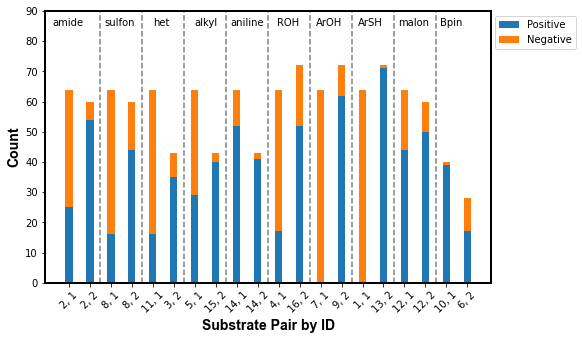

In [4]:
abbv = ["amide", "sulfon", "het", "alkyl", "aniline", 
         "ROH", "ArOH", "ArSH", "malon", "Bpin"]
pos_rxns = []
neg_rxns = []
reactant = []

for domain in domains :
    id_array = full_id_arrays_by_nuc[domain]
    reactant_pairs = np.unique(id_array[:,:2], axis=0)
    reactant_pairs = reactant_pairs[reactant_pairs[:, 1].argsort()]
    for pair in reactant_pairs :
        reactant.append(f"{int(pair[0])}, {int(pair[1])}")
        len_rxn = len(np.where(np.all(id_array[:,:2]==pair, axis=1)==True)[0])
        pos_rxn = np.sum(full_y_arrays_by_nuc[domain][np.where(np.all(id_array[:,:2]==pair, axis=1)==True)[0]])
        pos_rxns.append(pos_rxn)
        neg_rxns.append(len_rxn - pos_rxn)

ind = np.arange(len(reactant))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
p1 = plt.bar(ind, pos_rxns, width)
p2 = plt.bar(ind, neg_rxns, width, bottom=pos_rxns)
for x in [2,4,6,8,10,12,14,16,18] :
    plt.vlines(x-0.5, ymin=0, ymax=100, linestyles='dashed', colors='black', alpha=0.5)
annotate_x = [0, 2.5, 4.8, 6.8, 8.5, 10.7, 12.6, 14.6, 16.5,18.5]
for abv in abbv :
    ind_abv = abbv.index(abv)
    plt.annotate(abv, xy=(0,0), xytext=(annotate_x[ind_abv]-0.8,85))
plt.ylim([0,90])
plt.ylabel("Count", fontweight="bold", fontname="Arial", fontsize=14)
plt.xlabel("Substrate Pair by ID", fontweight="bold", fontname="Arial", fontsize=14)
plt.xticks(ind, reactant, rotation=45)
plt.legend((p1[0], p2[0]), ("Positive", "Negative"),
          bbox_to_anchor=(1.2,1.0))
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
#plt.savefig("./figures/figureS1.pdf", dpi=300, format='pdf', 
#            bbox_inches="tight")